# LDA

### Scatter matrices

$$\begin{align*}
S_w &= \sum_{c} S_c \\
S_c &= \sum_{i \in c} (x_i - \mu_i) \cdot (x_i - \mu_i)^\mathsf{T} = \Sigma_c \\
S_b &= \sum_{c} n_c \cdot (\mu_c - \mu) \cdot (\mu_c - \mu)^\mathsf{T} \\
\end{align*}$$

### Fit

1. Calculate within class scatter matrix $S_w$
2. Calculate between class scatter matrix $S_b$
3. Calculate the eigenvalues and eigenvectors of $S_w^{-1}S_b$
4. Sort the eigenvalues and eigenvectors in decreasing order
5. Store the first $n$ eigenvectors to be linear discriminants

### Transform

1. Project the data onto the linear discriminants

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [3]:
class LDA:

    def __init__(self, n_components: int) -> None:
        """
        Linear Discriminant Analysis model.

        Parameters
        ----------
        n_components : int
            Number of components for dimensionality reduction.

        Attributes
        ----------
        linear_discriminats : numpy.ndarray, default=None
            Vectors that the data is projected onto after fitting.
        """
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the Linear Discriminant Analysis model.

        Parameters
        ----------
        X : numpy.ndarray
            Training data of shape (n_samples, n_features).

        y : numpy.ndarray
            Target values of shape (n_samples,).

        Returns
        -------
        None
        """
        # Get the number of features
        n_features = X.shape[1]
        # Class labels
        classes = np.unique(y)

        # Initialize empty scatter matrices
        S_w = np.zeros((n_features, n_features))
        S_b = np.zeros((n_features, n_features))
        
        # Get the mean of the dataset
        mean = np.mean(X, axis=0)

        for c in classes:

            # Current class samples
            X_c = X[y == c]
            # Current class mean
            mean_c = np.mean(X_c, axis=0)

            # Within class scatter matrix (class covariance)
            S_w += np.cov(X_c.T)

            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean).reshape(n_features, 1)
            # Between class scatter matrix
            S_b += n_c * np.dot(mean_diff, mean_diff.T)

        # Calculate the inverse of S_w
        S_w_inv = np.linalg.inv(S_w)
        # Calculate the matrix A as the dot product of inverse of S_w and S_b
        A = np.dot(S_w_inv, S_b)

        # Solve for eigenvectors and eigenvalues
        eigvalues, eigvectors = np.linalg.eig(A)
        eigvectors = eigvectors.T

        # Sort the eigenvalues in descending order
        sorted_idx = np.argsort(np.abs(eigvalues))[::-1]

        # Sort the eigenvectors in descending order
        eigvectors = eigvectors[sorted_idx]

        # Select the first n eigenvectors to be linear discriminants
        self.linear_discriminants = eigvectors[:self.n_components]

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform the data to maximize class separation.

        Parameters
        ----------
        X : numpy.ndarray
            Data of shape (n_samples, n_features).

        Returns
        -------
        X_new : numpy.ndarray
            Transformed data of shape (n_samples, n_components)
        """
        # Project data onto the linear discriminants
        return np.dot(X, self.linear_discriminants.T)

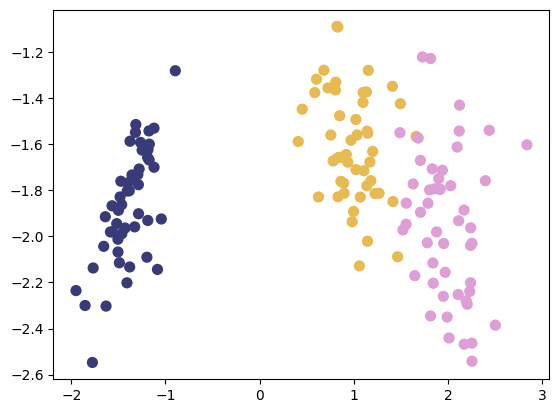

In [4]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

lda = LDA(n_components=2)
lda.fit(X, y)

X_new = lda.transform(X)
plot_2d_clf_problem(X_new, y)